In [1]:
import scanpy as sc

In [2]:
adata = sc.read_h5ad('../../data/RREAE_5k_raw_integration_processed.h5ad')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [7]:
adata.obs.index = adata.obs.index.astype(str)
adata.obs_names_make_unique()

In [8]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

def _to_dense(X):
    return X.toarray() if sp.issparse(X) else np.asarray(X)

def _get_matrix(adata, layer=None):
    if layer is None:
        return adata.X
    if layer in adata.layers:
        return adata.layers[layer]
    raise ValueError(f"Layer '{layer}' not found. Available: {list(adata.layers.keys())}")

def _compute_logcpm(adata, layer=None):
    X = _to_dense(_get_matrix(adata, layer))
    lib = X.sum(axis=1, keepdims=True)
    lib[lib == 0] = 1
    return np.log1p((X / lib) * 1e6)

def compute_dotplot_stats(
    adata,
    genes,
    celltype_col="celltype_merged",
    course_col="course",
    counts_layer="raw",
    selected_celltypes=None,      # e.g. ["Astrocyte"]
    selected_courses=None,        # e.g. ["PLP CFA","peak I","peak II","peak III"]
    min_cells_per_group=0         # drop (celltype×course) groups with < N cells
):
    """
    Returns a tidy DataFrame:
      [celltype_col, course_col, 'gene', 'mean_logcpm', 'pct_expressing']
    suitable for Scanpy-style dotplots or your dual-axis line plots.
    """
    # -------- subset adata --------
    mask = pd.Series(True, index=adata.obs_names)
    if selected_celltypes is not None:
        mask &= adata.obs[celltype_col].astype(str).isin(selected_celltypes)
    if selected_courses is not None:
        mask &= adata.obs[course_col].astype(str).isin(selected_courses)
    if mask.sum() == 0:
        raise ValueError("No cells left after filtering cell types / courses.")

    ad = adata[mask].copy()
    ad.obs_names_make_unique()

    # normalize dtypes to strings to avoid categorical/setitem pitfalls
    ad.obs[celltype_col] = ad.obs[celltype_col].astype(str)
    ad.obs[course_col]   = ad.obs[course_col].astype(str)

    # keep only existing genes
    genes = [g for g in genes if g in ad.var_names]
    if not genes:
        raise ValueError("None of the requested genes are in adata.var_names.")

    # -------- per-cell logCPM --------
    logcpm = _compute_logcpm(ad, layer=counts_layer)
    logcpm_df = pd.DataFrame(logcpm, index=ad.obs_names, columns=ad.var_names)[genes]

    # -------- long format + metadata --------
    long = (
        logcpm_df.stack().rename("logcpm").reset_index()
        .rename(columns={"level_0":"cell_id","level_1":"gene"})
        .merge(
            ad.obs[[celltype_col, course_col]].reset_index().rename(columns={"index":"cell_id"}),
            on="cell_id", how="left"
        )
    )

    # optional: drop tiny (celltype×course) groups
    if min_cells_per_group and min_cells_per_group > 0:
        sizes = long.groupby([celltype_col, course_col]).size()
        keep = sizes[sizes >= min_cells_per_group].index
        long = long.set_index([celltype_col, course_col]).loc[keep].reset_index()
        if long.empty:
            raise ValueError("All (celltype×course) groups dropped by min_cells_per_group.")

    # -------- aggregate to stats --------
    stats = (
        long.groupby([celltype_col, course_col, "gene"], observed=True)
            .agg(
                mean_logcpm=("logcpm","mean"),
                pct_expressing=("logcpm", lambda x: (x > 0).mean() * 100.0)
            )
            .reset_index()
    )

    # -------- preserve user orderings --------
    stats["gene"] = pd.Categorical(stats["gene"], categories=genes, ordered=True)
    if selected_courses is not None:
        stats[course_col] = pd.Categorical(stats[course_col],
                                           categories=selected_courses, ordered=True)
    if selected_celltypes is not None:
        stats[celltype_col] = pd.Categorical(stats[celltype_col],
                                             categories=selected_celltypes, ordered=True)

    # final tidy, ordered
    stats = stats.sort_values([celltype_col, course_col, "gene"]).reset_index(drop=True)
    return stats

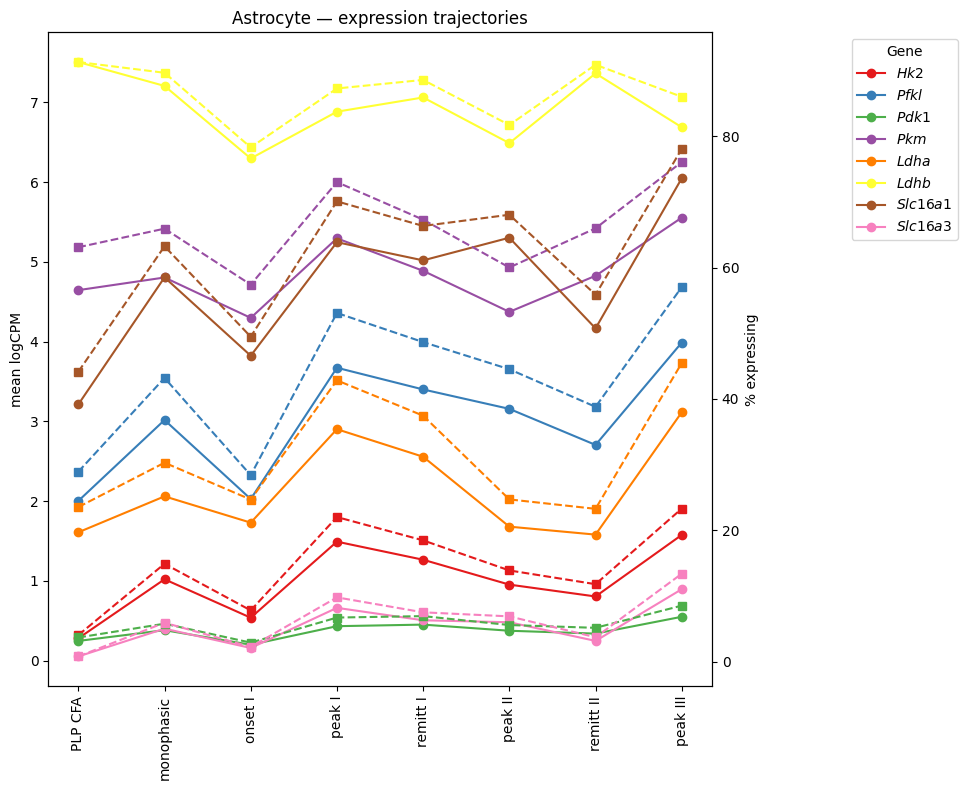

In [9]:
# compute the tidy stats table
stats = compute_dotplot_stats(
    adata,
    genes=[ 'Hk2',
 'Pfkl',
 'Pdk1',
 'Pkm',
 'Ldha',
 'Ldhb',
 'Slc16a1',
 'Slc16a3'],
    celltype_col="celltype_merged",
    course_col="course",
    counts_layer="raw",
    selected_celltypes=["Astrocyte"],                # optional filter
    selected_courses=['PLP CFA','monophasic','onset I','onset II',
    'peak I','remitt I','peak II','remitt II','peak III'],  # keep order
    min_cells_per_group=20
)

# your plot (unchanged)
import matplotlib.pyplot as plt
import seaborn as sns

celltype = "Astrocyte"
genes_to_plot = [ 'Hk2',
 'Pfkl',
 'Pdk1',
 'Pkm',
 'Ldha',
 'Ldhb',
 'Slc16a1',
 'Slc16a3',]
palette = sns.color_palette("Set1", n_colors=len(genes_to_plot))

fig, ax1 = plt.subplots(figsize=(10,8))

# left axis = mean logCPM
for g, col in zip(genes_to_plot, palette):
    df = stats.query("gene == @g and celltype_merged == @celltype")
    ax1.plot(df["course"], df["mean_logcpm"],
             marker="o", color=col, label=fr"$\it{{{g}}}$")

ax1.set_ylabel("mean logCPM")
ax1.tick_params(axis="y", labelcolor="black")

# right axis = % expressing
ax2 = ax1.twinx()
for g, col in zip(genes_to_plot, palette):
    df = stats.query("gene == @g and celltype_merged == @celltype")
    ax2.plot(df["course"], df["pct_expressing"],
             marker="s", linestyle="--", color=col)

ax2.set_ylabel("% expressing")
ax2.tick_params(axis="y", labelcolor="black")

ax1.set_title(f"{celltype} — expression trajectories")
# after plotting
ax1.set_xticks(range(len(stats["course"].unique())))
ax1.set_xticklabels(stats["course"].unique(), rotation=90)
ax1.legend(bbox_to_anchor=(1.2,1), loc="upper left", title="Gene")
plt.tight_layout()
plt.show()

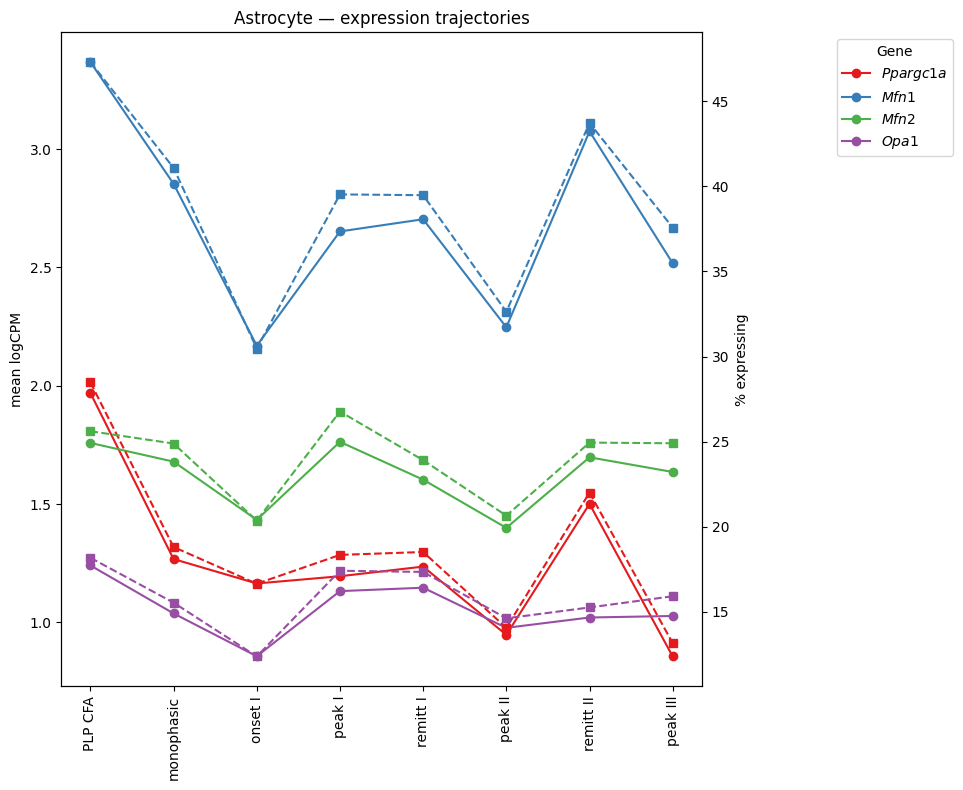

In [10]:
# compute the tidy stats table
stats = compute_dotplot_stats(
    adata,
    genes=[  'Ppargc1a',
 'Mfn1',
 'Mfn2',
 'Opa1',],
    celltype_col="celltype_merged",
    course_col="course",
    counts_layer="raw",
    selected_celltypes=["Astrocyte"],                # optional filter
    selected_courses=['PLP CFA','monophasic','onset I','onset II',
    'peak I','remitt I','peak II','remitt II','peak III'],  # keep order
    min_cells_per_group=20
)

# your plot (unchanged)
import matplotlib.pyplot as plt
import seaborn as sns

celltype = "Astrocyte"
genes_to_plot = [ 'Ppargc1a',
 'Mfn1',
 'Mfn2',
 'Opa1',]
palette = sns.color_palette("Set1", n_colors=len(genes_to_plot))

fig, ax1 = plt.subplots(figsize=(10,8))

# left axis = mean logCPM
for g, col in zip(genes_to_plot, palette):
    df = stats.query("gene == @g and celltype_merged == @celltype")
    ax1.plot(df["course"], df["mean_logcpm"],
             marker="o", color=col, label=fr"$\it{{{g}}}$")

ax1.set_ylabel("mean logCPM")
ax1.tick_params(axis="y", labelcolor="black")

# right axis = % expressing
ax2 = ax1.twinx()
for g, col in zip(genes_to_plot, palette):
    df = stats.query("gene == @g and celltype_merged == @celltype")
    ax2.plot(df["course"], df["pct_expressing"],
             marker="s", linestyle="--", color=col)

ax2.set_ylabel("% expressing")
ax2.tick_params(axis="y", labelcolor="black")

ax1.set_title(f"{celltype} — expression trajectories")
# after plotting
ax1.set_xticks(range(len(stats["course"].unique())))
ax1.set_xticklabels(stats["course"].unique(), rotation=90)
ax1.legend(bbox_to_anchor=(1.2,1), loc="upper left", title="Gene")
plt.tight_layout()
plt.show()

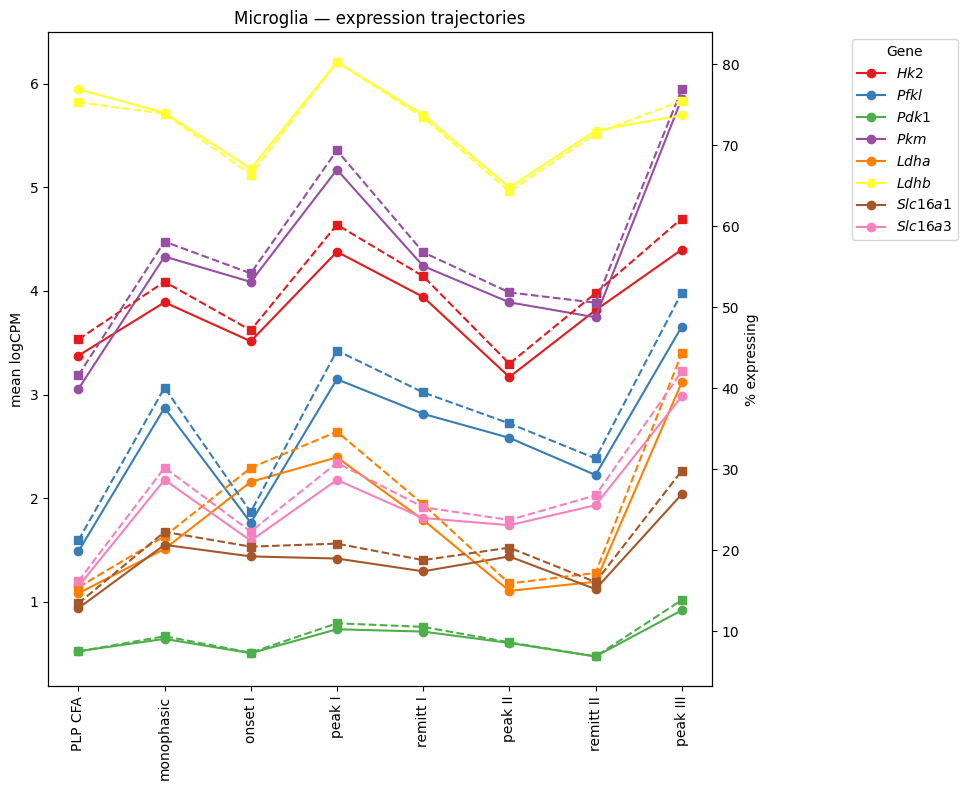

In [11]:
# compute the tidy stats table
stats = compute_dotplot_stats(
    adata,
    genes=[ 'Hk2',
 'Pfkl',
 'Pdk1',
 'Pkm',
 'Ldha',
 'Ldhb',
 'Slc16a1',
 'Slc16a3'],
    celltype_col="celltype_merged",
    course_col="course",
    counts_layer="raw",
    selected_celltypes=["Microglia"],                # optional filter
    selected_courses=['PLP CFA','monophasic','onset I','onset II',
    'peak I','remitt I','peak II','remitt II','peak III'],  # keep order
    min_cells_per_group=20
)

# your plot (unchanged)
import matplotlib.pyplot as plt
import seaborn as sns

celltype = "Microglia"
genes_to_plot = [ 'Hk2',
 'Pfkl',
 'Pdk1',
 'Pkm',
 'Ldha',
 'Ldhb',
 'Slc16a1',
 'Slc16a3',]
palette = sns.color_palette("Set1", n_colors=len(genes_to_plot))

fig, ax1 = plt.subplots(figsize=(10,8))

# left axis = mean logCPM
for g, col in zip(genes_to_plot, palette):
    df = stats.query("gene == @g and celltype_merged == @celltype")
    ax1.plot(df["course"], df["mean_logcpm"],
             marker="o", color=col, label=fr"$\it{{{g}}}$")

ax1.set_ylabel("mean logCPM")
ax1.tick_params(axis="y", labelcolor="black")

# right axis = % expressing
ax2 = ax1.twinx()
for g, col in zip(genes_to_plot, palette):
    df = stats.query("gene == @g and celltype_merged == @celltype")
    ax2.plot(df["course"], df["pct_expressing"],
             marker="s", linestyle="--", color=col)

ax2.set_ylabel("% expressing")
ax2.tick_params(axis="y", labelcolor="black")

ax1.set_title(f"{celltype} — expression trajectories")
# after plotting
ax1.set_xticks(range(len(stats["course"].unique())))
ax1.set_xticklabels(stats["course"].unique(), rotation=90)
ax1.legend(bbox_to_anchor=(1.2,1), loc="upper left", title="Gene")
plt.tight_layout()
plt.show()

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_multi_celltypes_dual_axes(
    stats,
    celltypes_to_plot,
    genes_to_plot,
    course_order=None,
    palette=None,
    height=10.0,
    width_per_panel=10.0,
    rotate_xticks=90
):
    """
    Side-by-side panels: one subplot per cell type.
    Each subplot shows multiple genes:
      - left y-axis: mean_logcpm (solid)
      - right y-axis: pct_expressing (dashed)
    """

    # keep order as provided by user
    celltypes_to_plot = [c for c in celltypes_to_plot
                         if c in stats["celltype_merged"].astype(str).unique()]
    if not celltypes_to_plot:
        raise ValueError("None of the requested cell types are present in 'stats'.")

    # course order from stats if not provided
    if course_order is None:
        if hasattr(stats["course"], "cat"):
            course_order = list(stats["course"].cat.categories)
        else:
            # preserve first-seen order
            course_order = list(pd.unique(stats["course"].astype(str)))
    # ensure categorical for stable ordering
    stats = stats.copy()
    stats["course"] = pd.Categorical(stats["course"].astype(str),
                                     categories=course_order, ordered=True)

    # limit to requested genes (keep given order)
    genes_clean = [g for g in genes_to_plot if g in stats["gene"].unique()]
    if not genes_clean:
        raise ValueError("None of the genes_to_plot are present in 'stats'.")
    stats["gene"] = pd.Categorical(stats["gene"], categories=genes_clean, ordered=True)

    # colors
    if palette is None:
        palette = sns.color_palette("Set1", n_colors=len(genes_clean))

    # x positions
    x_positions = np.arange(len(course_order))

    # figure
    n = len(celltypes_to_plot)
    fig, axes = plt.subplots(
        1, n, figsize=(width_per_panel * n, height), sharey=False
    )
    if n == 1:
        axes = [axes]

    # plotting helper to align values to course_order (keeps gaps as NaN)
    def align_series(df_gene, value_col):
        return df_gene.set_index("course")[value_col].reindex(course_order).values

    for ax, celltype in zip(axes, celltypes_to_plot):
        dat = stats.loc[stats["celltype_merged"].astype(str) == str(celltype)].copy()
        if dat.empty:
            ax.set_visible(False)
            continue

        # left axis: mean logCPM
        for g, col in zip(genes_clean, palette):
            df_g = dat.loc[dat["gene"] == g, ["course", "mean_logcpm"]]
            y = align_series(df_g, "mean_logcpm")
            ax.plot(x_positions, y, marker="o", color=col, label=fr"$\it{{{g}}}$")

        ax.set_ylabel("mean logCPM")
        ax.tick_params(axis="y", labelcolor="black")
        ax.set_title(str(celltype))

        # right axis: % expressing
        ax2 = ax.twinx()
        for g, col in zip(genes_clean, palette):
            df_g = dat.loc[dat["gene"] == g, ["course", "pct_expressing"]]
            y = align_series(df_g, "pct_expressing")
            ax2.plot(x_positions, y, marker="s", linestyle="--", color=col)
        ax2.set_ylabel("% expressing")
        ax2.tick_params(axis="y", labelcolor="black")

        # x-axis ticks/labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels(course_order, rotation=rotate_xticks)

    # shared legend (from the last axis that has labels)
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc="upper left", title="Genes")

    plt.suptitle("Expression trajectories across cell types", y=1.02)
    plt.tight_layout()
    plt.show()

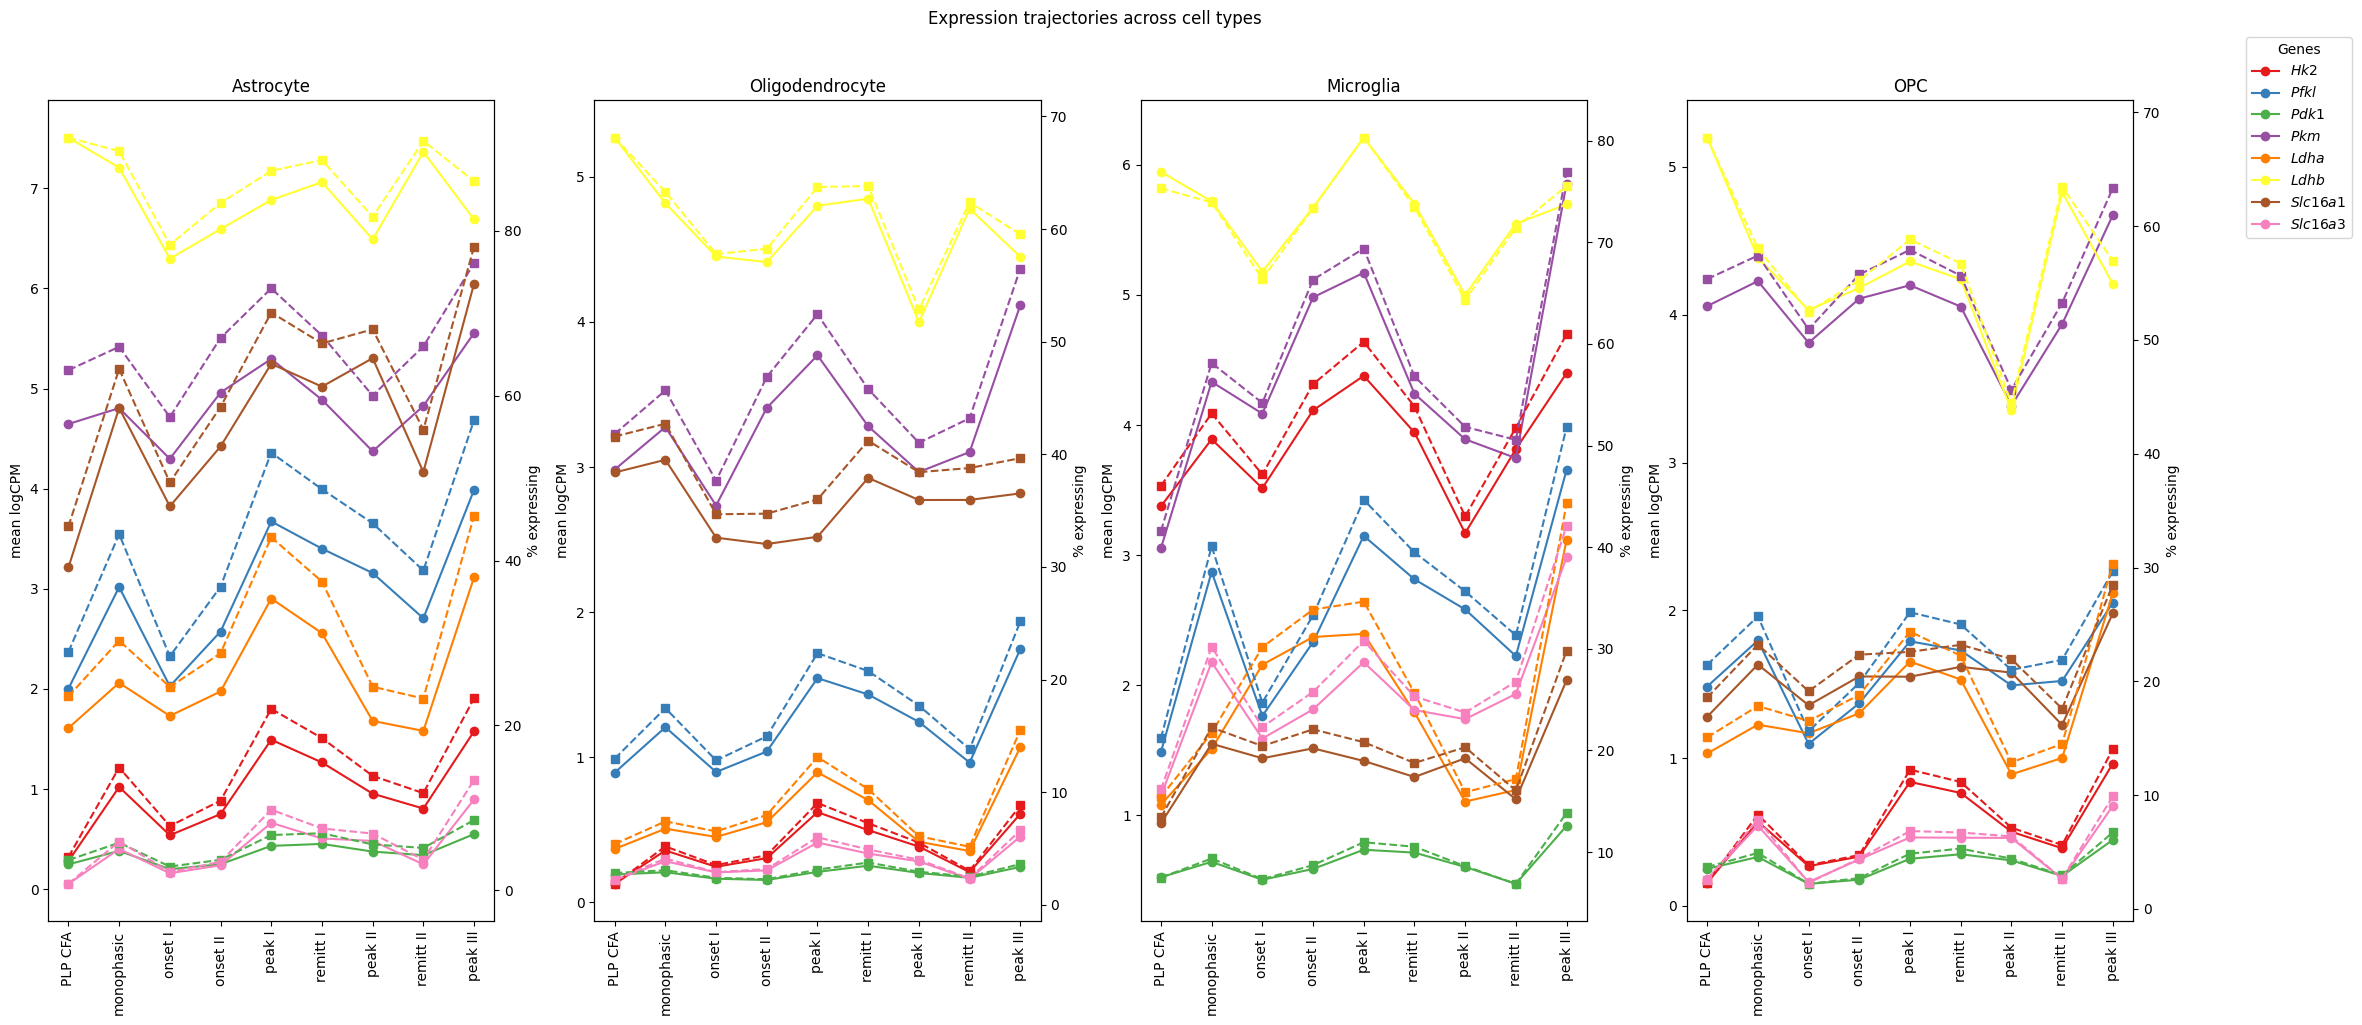

In [15]:
# 1) Compute stats for ALL the cell types you want to show (not just Astrocyte)
celltypes_to_plot = ["Astrocyte", "Oligodendrocyte", "Microglia", "OPC"]
course_order = ['PLP CFA','monophasic','onset I','onset II ',
                'peak I','remitt I','peak II','remitt II','peak III']

stats = compute_dotplot_stats(
    adata,
    genes=['Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3'],
    celltype_col="celltype_merged",
    course_col="course",
    counts_layer="raw",
    selected_celltypes=celltypes_to_plot,  # include all you want to plot
    selected_courses=course_order,         # fix order
    min_cells_per_group=20
)

# 2) Plot side-by-side panels
plot_multi_celltypes_dual_axes(
    stats=stats,
    celltypes_to_plot=celltypes_to_plot,
    genes_to_plot=['Hk2','Pfkl','Pdk1','Pkm','Ldha','Ldhb','Slc16a1','Slc16a3'],
    course_order=course_order,
    width_per_panel=5.5,         # tune for spacing
    rotate_xticks=90
)

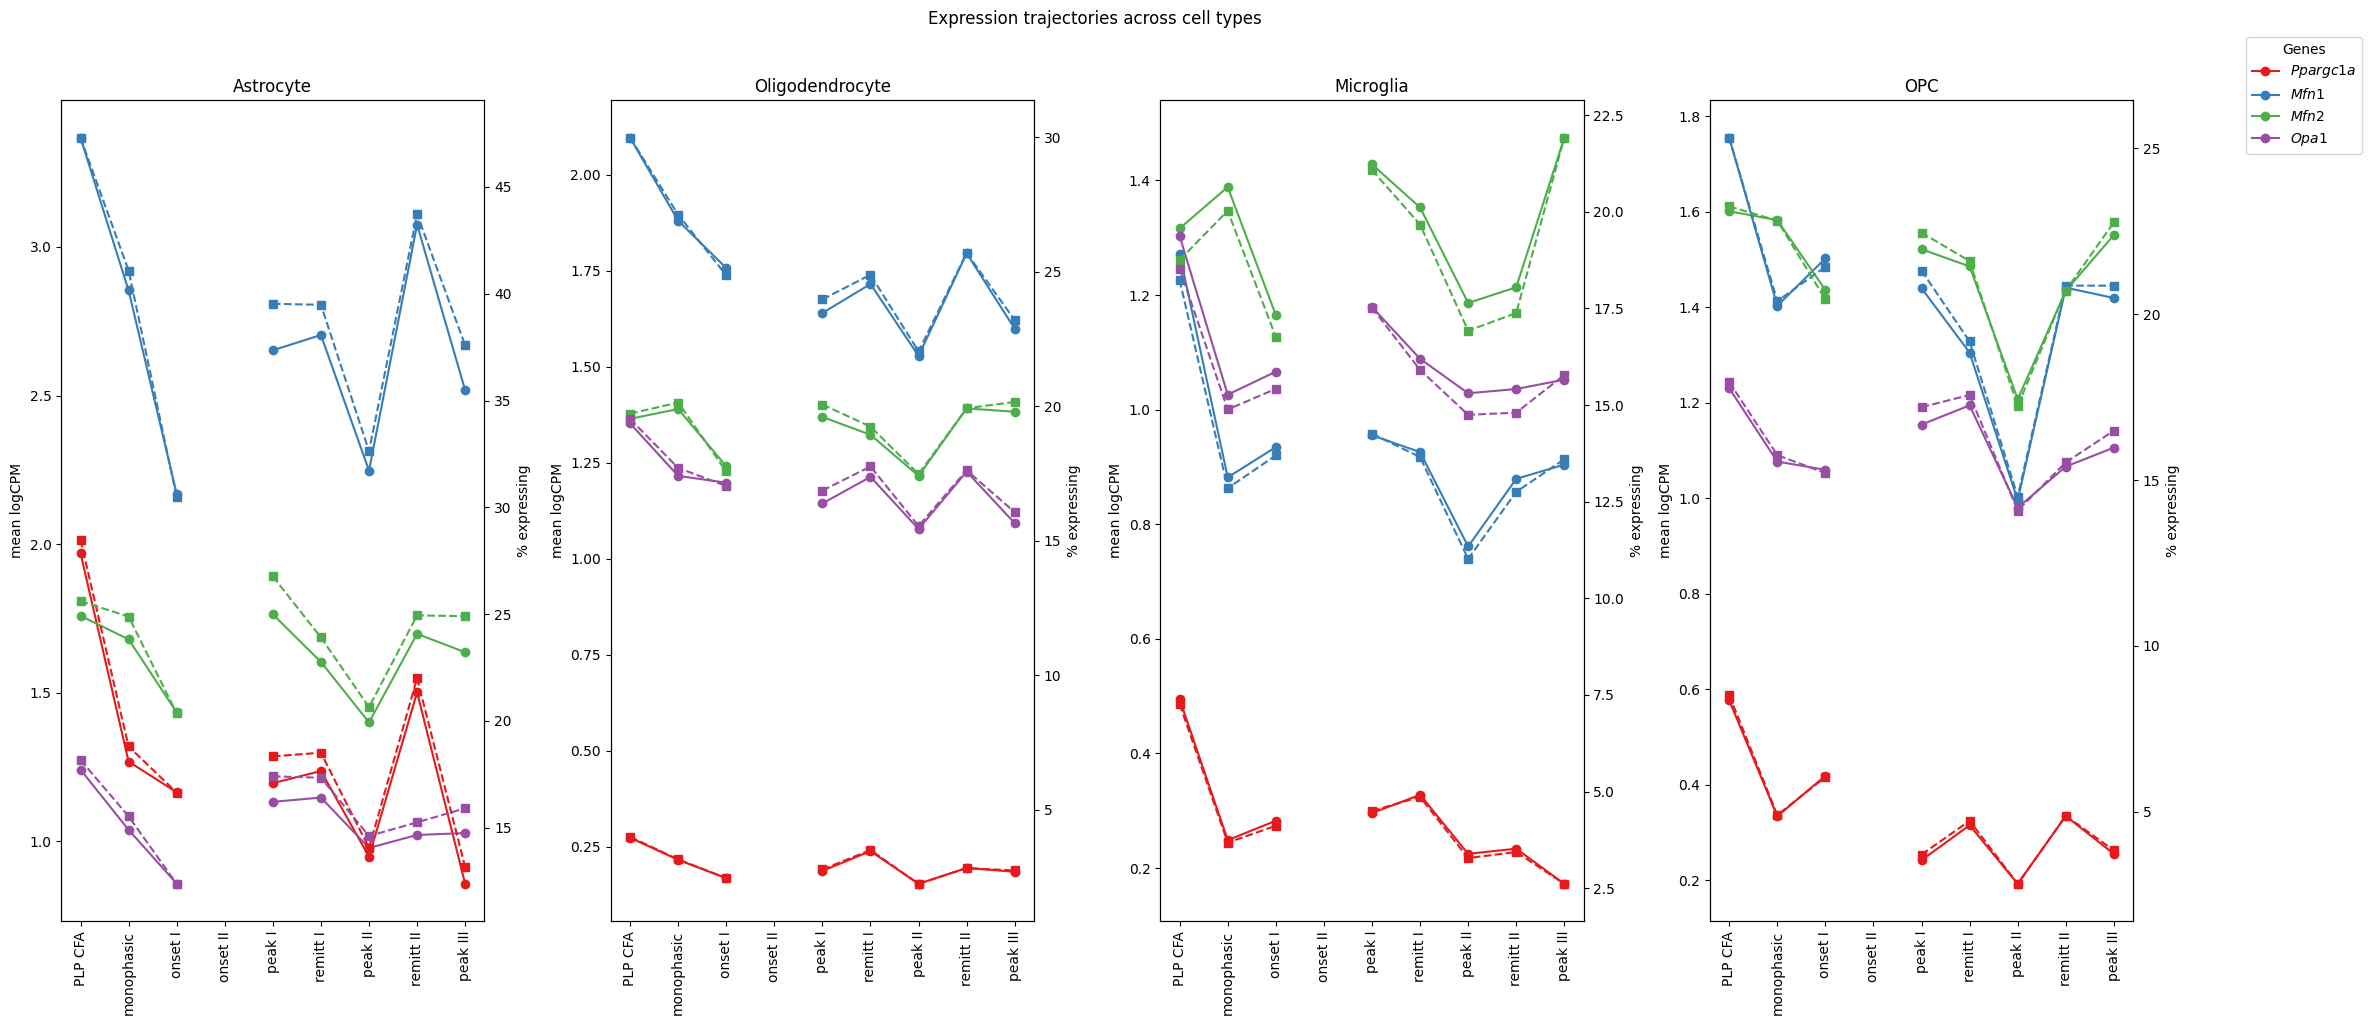

In [14]:
# 1) Compute stats for ALL the cell types you want to show (not just Astrocyte)
celltypes_to_plot = ["Astrocyte", "Oligodendrocyte", "Microglia", "OPC"]
course_order = ['PLP CFA','monophasic','onset I','onset II',
                'peak I','remitt I','peak II','remitt II','peak III']

stats = compute_dotplot_stats(
    adata,
    genes=['Ppargc1a',
 'Mfn1',
 'Mfn2',
 'Opa1',],
    celltype_col="celltype_merged",
    course_col="course",
    counts_layer="raw",
    selected_celltypes=celltypes_to_plot,  # include all you want to plot
    selected_courses=course_order,         # fix order
    min_cells_per_group=20
)

# 2) Plot side-by-side panels
plot_multi_celltypes_dual_axes(
    stats=stats,
    celltypes_to_plot=celltypes_to_plot,
    genes_to_plot=['Ppargc1a',
 'Mfn1',
 'Mfn2',
 'Opa1',],
    course_order=course_order,
    width_per_panel=5.5,         # tune for spacing
    rotate_xticks=90
)